In [62]:
import requests
import pandas as pd
pd.options.mode.chained_assignment = None
import json

## Get data from GOV DATA

try:
    #response = requests.get('https://datos.gob.cl/api/3/action/datastore_search?resource_id=2c44d782-3365-44e3-aefb-2c8b8363a1bc')
    response = requests.get("https://datos.gob.cl/api/3/action/datastore_search_sql?sql=SELECT%20*%20from%20%222c44d782-3365-44e3-aefb-2c8b8363a1bc%22")
   
except:
    print("No internet available")

## Create a variable to store the Json file contents
response_json = response.json()

## Display dataframe
response_json_fields = response_json['result']['fields']
response_json_data = response_json['result']['records']
df = pd.DataFrame(response_json_data)
df['Latitud'] = pd.to_numeric(df['Latitud'], errors='coerce')
df['Longitud'] = pd.to_numeric(df['Longitud'], errors='coerce')
## Print to check
print(df.info())
print(df.isnull().sum())
#print("number of records: ", len(df))
#print("number of columns: ", len(df.columns)) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8740 entries, 0 to 8739
Data columns (total 34 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   TipoAtencionEstabGlosa                   8740 non-null   object 
 1   SeremiSaludGlosa_ServicioDeSaludGlosa    8740 non-null   object 
 2   RegionCodigo                             8740 non-null   object 
 3   _full_text                               8740 non-null   object 
 4   ComunaCodigo                             8740 non-null   object 
 5   ClasificacionTipoSapu                    8740 non-null   object 
 6   AmbitoFuncionamiento                     8740 non-null   object 
 7   FechaIncorporacion                       941 non-null    object 
 8   EstablecimientoCodigo                    8740 non-null   object 
 9   FechaInicioFuncionamientoEstab           3705 non-null   object 
 10  Numero                                   8740 no

Remove rows where Latitud or Longitud are nulls

In [66]:
df= df.dropna(subset=['Latitud', 'Longitud'])
## Print to check
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 8326 entries, 0 to 8639
Data columns (total 34 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   TipoAtencionEstabGlosa                   8326 non-null   object 
 1   SeremiSaludGlosa_ServicioDeSaludGlosa    8326 non-null   object 
 2   RegionCodigo                             8326 non-null   object 
 3   _full_text                               8326 non-null   object 
 4   ComunaCodigo                             8326 non-null   object 
 5   ClasificacionTipoSapu                    8326 non-null   object 
 6   AmbitoFuncionamiento                     8326 non-null   object 
 7   FechaIncorporacion                       561 non-null    object 
 8   EstablecimientoCodigo                    8326 non-null   object 
 9   FechaInicioFuncionamientoEstab           3341 non-null   object 
 10  Numero                                   8326 non-nul

Create distributions based in some of th emost important segmentations such as:
1. TipoSistemaSaludGlosa
2. EstadoFuncionamiento
3. TipoUrgencia
5. TieneServicioUrgencia
6. NivelAtencionEstabglosa
8. TipoEstablecimientoGlosa

In [63]:
import seaborn as sns
import seaborn.objects as so
import textwrap
import re

def plot_dist(dataset, segment):
    #Add spaces between words in the column name nad remove Glosa
    fix = (re.sub(r"(\w)([A-Z])", r"\1 \2", segment)) #.replace('Glosa','')
    #Normalize column string values
    dataset[segment] = dataset[segment].str.capitalize()
    #Plot only the top 10 types
    ax = sns.countplot(dataset, y=segment, order=dataset[segment].value_counts().iloc[:10].index)
    ax.bar_label(ax.containers[0])
    ax.set(
        xlabel='# centros',
        ylabel="",        
        )
    #ax.set_yticklabels(ax.get_yticklabels(), ha='right')
    ax.set_title(label=f'Distribución de centros por {fix} ( Top 10 )',loc='right')
    return ax

<Axes: title={'right': 'Distribución de centros por Tipo Sistema Salud Glosa ( Top 10 )'}, xlabel='# centros'>

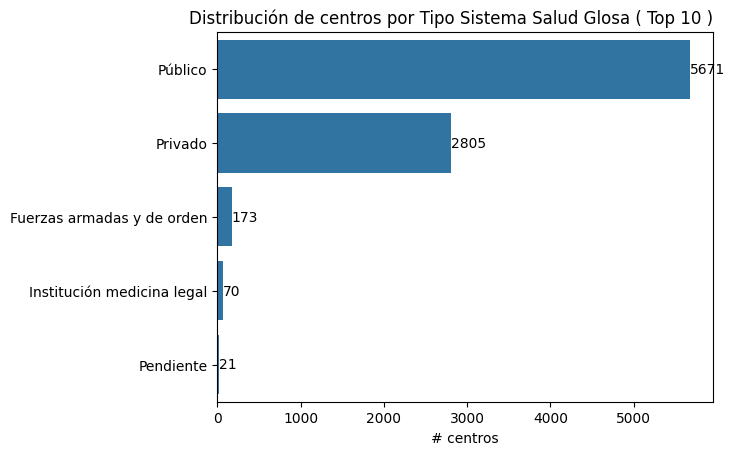

In [64]:
plot_dist(df,'TipoSistemaSaludGlosa')
#plot_dist(df,'TipoEstablecimientoGlosa')

Create the charts using plotly instead

In [65]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_bar_h(dataset, segment):
    #Add spaces between words in the column name nad remove Glosa
    fix = (re.sub(r"(\w)([A-Z])", r"\1 \2", segment)) #.replace('Glosa','')
    #Normalize column string values
    dataset[segment] = dataset[segment].str.capitalize()
    #Plot only the top 10 types
    fig = px.bar(
                dataset[segment].value_counts(),
                orientation='h', 
                title=f'Distribución de centros por {fix}',
                labels={'value': '# centros', segment :''}
                )
    fig.update_layout(
                yaxis={'categoryorder':'total ascending'},
                showlegend=False,
                hovermode='y'
                )
    return fig

#plot_bar_h(df, 'TipoSistemaSaludGlosa')
plot_bar_h(df,'TipoEstablecimientoGlosa')

#fig = px.histogram(df, y='TipoSistemaSaludGlosa', orientation='h')
#fig.show()

Create a function that will create a map to plot the different centers 

In [67]:
# Import libraries needed to create the map
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon

# Function to create the map

def plot_map(subset_val):
    ## Create new dataset with coordinate data point with new lat/log as numeric
    mdf = gpd.GeoDataFrame(subset_val ,crs="EPSG:4326", geometry=gpd.points_from_xy(subset_val.Longitud, subset_val.Latitud))
    # Get the center from the subset
    center = (mdf['Latitud'].mean(), mdf['Longitud'].mean())
    ## Create map and export to html
    
    import folium
    interactive_map = folium.Map(
        location=center, 
        zoom_start=13, 
        control_scale=True, 
        tiles="https://mt1.google.com/vt/lyrs=r&x={x}&y={y}&z={z}",
        attr="Google maps"
        )
    tooltip_info = folium.GeoJsonTooltip(
        fields=['EstablecimientoGlosa','TipoEstablecimientoGlosa', 'ComunaGlosa' ,'TieneServicioUrgencia' ],
        aliases=['Nombre:', 'Tipo:', 'Dirección:', 'Tiene Urgencia:'],
        localize=True,
        sticky=False,
        labels=True,
        max_width=800
        )
    addresses_layer = folium.features.GeoJson(
        mdf,
        name="Servicios de Salud",
        #popup=popup_info
        tooltip=tooltip_info
        )
    addresses_layer.add_to(interactive_map)
    ## Save the map as html code to later use it with Dash
    src_doc_val = interactive_map.get_root().render()

    return src_doc_val


Define layout needed for the App

1. Menu with 2 dropw down lists
2. Two charts
3. A Map


In [68]:
## To make the app interactive, we need to create a function that will create the map based on the selected parameters by the user
## IN this case we will have  2 parameters : Region and Comuna
## Based on the selected Region and Comuna , we need to perform the several steps :
##  a.  Create a subset dataset based on the region and comuna selected
##  b.  Create the map using the outputs of a and b

# Create 2 more datasets that will contain the unique list of comunas and regions
lista_comunas = df['ComunaGlosa'].sort_values().unique()
lista_regiones = df['RegionGlosa'].sort_values().unique()
print(lista_comunas, lista_regiones)

['Aisén' 'Algarrobo' 'Alhué' 'Alto Biobío' 'Alto Hospicio'
 'Alto del Carmen' 'Ancud' 'Andacollo' 'Angol' 'Antofagasta' 'Antuco'
 'Arauco' 'Arica' 'Buin' 'Bulnes' 'Cabildo' 'Cabo de Hornos' 'Cabrero'
 'Calama' 'Calbuco' 'Caldera' 'Calera' 'Calera de Tango' 'Calle Larga'
 'Camarones' 'Camiña' 'Canela' 'Carahue' 'Cartagena' 'Casablanca' 'Castro'
 'Catemu' 'Cauquenes' 'Cañete' 'Cerrillos' 'Cerro Navia' 'Chaitén'
 'Chanco' 'Chañaral' 'Chepica' 'Chiguayante' 'Chile Chico' 'Chillán'
 'Chillán Viejo' 'Chimbarongo' 'Cholchol' 'Chonchi' 'Cisnes' 'Cobquecura'
 'Cochamó' 'Cochrane' 'Codegua' 'Coelemu' 'Coihueco' 'Coinco' 'Colbún'
 'Colchane' 'Colina' 'Collipulli' 'Coltauco' 'Combarbalá' 'Con Con'
 'Concepción' 'Conchalí' 'Constitución' 'Contulmo' 'Copiapó' 'Coquimbo'
 'Coronel' 'Corral' 'Coyhaique' 'Cunco' 'Curacautín' 'Curacaví'
 'Curaco de Vélez' 'Curanilahue' 'Curarrehue' 'Curepto' 'Curicó'
 'Dalcahue' 'Diego de Almagro' 'Doñihue' 'El Bosque' 'El Carmen'
 'El Monte' 'El Quisco' 'El Tabo' 'Empe

Define the app layout

In [69]:
# app.py
import dash
from dash import Dash, html, dcc, callback, Output, Input, dash_table

## Define the Application

app = Dash(__name__)
app.title = 'Aplicación para buscar centros de salud en Chile'

app.layout = html.Div(
    className='row',
    children=
    [
        #Title:
        html.H1('Centros de Salud en Chile'),
        #Dropdpwns
        html.Div(
            children=
            [
            dcc.Dropdown(id="dropdown-region",
                         #style={'display': 'inline-block'},
                         options=[
                            {
                                "label": reg_nm, 
                                "value": reg_nm
                            }
                            for reg_nm in lista_regiones
                         ],
                         clearable=True,
                        ),
            dcc.Dropdown(id="dropdown-comuna",
                         #style={'display': 'inline-block'},
                         options=[],
                         clearable=True,
                         )
            ]
        ),
        #Charts and Map
        html.Div(
            children=
            [
            dcc.Graph(id="graph1", style={'display': 'inline-block'}),
            dcc.Graph(id="graph2", style={'display': 'inline-block'})
            ]
        ),
        #Map
        html.Div(id='map')
    ]
)
## First callback to get the list of comunas from the selected Region
@app.callback(
        Output('dropdown-comuna', 'options'),
        Input('dropdown-region', 'value')
)
def get_comunas_options(region_val):
    filtered_list = df[df['RegionGlosa']== region_val]
    lista_comunas = filtered_list['ComunaGlosa'].sort_values().unique()
    return [{"label": cmn_nm, "value": cmn_nm} for cmn_nm in lista_comunas]

## Second callback to get the correct dataset and create the plots and map needed
@app.callback(
    Output('graph1', 'figure'),
    Output('graph2', 'figure'),
    Output('map', 'children'),
    Input('dropdown-region', 'value'),
    Input('dropdown-comuna', 'value')
)
def selected_map(region_val,comuna_val):
    # Create the dataset based on selection
    # 1. No selected region/comuna, use all data
    if (region_val is None or region_val ==[]) and (comuna_val is None or comuna_val ==[]):
        subset = df
        
    # 2. Select by region only 
    elif (comuna_val is None or comuna_val ==[]):
        subset = df[df['RegionGlosa']== region_val]
        
    # 3. Select comuna only
    elif (region_val is None or region_val ==[]):
        region_val=df[df['ComunaGlosa']== comuna_val]['RegionGlosa'].unique()
        subset = df[df['ComunaGlosa']== comuna_val]

    # 4. Selected Region and then comuna
    else:
        subset = df[(df['RegionGlosa']== region_val) & (df['ComunaGlosa']== comuna_val)]
        
        
    return plot_bar_h(subset, 'TipoSistemaSaludGlosa'), plot_bar_h(subset,'TipoEstablecimientoGlosa'), html.Iframe(srcDoc = plot_map(subset),width = '100%', height = '600')

if __name__ == "__main__":
    app.run_server(port=2223, debug=True)

New app version with a better layout using bootstrap containers

In [76]:
# app.py
import dash
from dash import Dash, html, dcc, callback, Output, Input, dash_table
import dash_bootstrap_components as dbc

## Define the Application

app = Dash(__name__, external_stylesheets=[dbc.themes.LITERA])

#First drowpdown will be region
region_drowpdown = html.Div(
    [
        html.Label('Select Region', htmlFor='dropdown-region'),
        dcc.Dropdown(id="dropdown-region",
                         options=[
                            {
                                "label": reg_nm, 
                                "value": reg_nm
                            }
                            for reg_nm in lista_regiones
                         ],
                         clearable=True,
                        )
    ]
)
# Second dropwdown will be comuna
comuna_dropdown = html.Div(
    [
        html.Label('Select Comuna', htmlFor='dropdown-comuna'),
        dcc.Dropdown(id="dropdown-comuna",
                         options=[],
                         clearable=True,
                         )
    ]
)
# First graph
graph1 = dbc.Card(
    dcc.Graph(id="graph1"),
    class_name='mt-2'
)
# Second graph
graph2 = dbc.Card(
    dcc.Graph(id="graph2"),
    class_name='mt-2'
)
# 3rd  graph
graph3 = dbc.Card(
    dcc.Graph(id="graph3"),
    class_name='mt-2'
)
# Card with Map
map1 = html.Div(
    [
        html.Label('Mapa de ', htmlFor='map'),
        html.Div(id='map')
    ]
)
## Create app layout
app.layout = dbc.Container(
    [
       #Title
       html.H2('Aplicación para buscar centros de salud en Chile',
               className='text-center'
        ),
       #Row with 2 columns, each will have a drowpdown
       dbc.Row(
           [
               dbc.Col(region_drowpdown),
               dbc.Col(comuna_dropdown)
           ]
       ),
       #Row with 3 columns, each will have a chart
       dbc.Row(
           [
               dbc.Col(graph1, width=4),
               dbc.Col(graph2, width=4),
               dbc.Col(graph3, width=4)
           ]
       ),
       #Space
       html.Br(),
       #Subtitle for the map
       html.H3('Find your centro in the map below',
               className='text-left'
       ),
       #Row with 1 column with the map
       dbc.Row(
           dbc.Col(map1)
       )
    ],
    fluid=True
)
## First callback to get the list of comunas from the selected Region
@app.callback(
        Output('dropdown-comuna', 'options'),
        Input('dropdown-region', 'value')
)
def get_comunas_options(region_val):
    filtered_list = df[df['RegionGlosa']== region_val]
    lista_comunas = filtered_list['ComunaGlosa'].sort_values().unique()
    return [{"label": cmn_nm, "value": cmn_nm} for cmn_nm in lista_comunas]

## Second callback to get the correct dataset and create the plots and map needed
@app.callback(
    Output('graph1', 'figure'),
    Output('graph2', 'figure'),
    Output('graph3', 'figure'),
    Output('map', 'children'),
    Input('dropdown-region', 'value'),
    Input('dropdown-comuna', 'value')
)
def selected_map(region_val,comuna_val):
    # Create the dataset based on selection
    # 1. No selected region/comuna, use all data
    if (region_val is None or region_val ==[]) and (comuna_val is None or comuna_val ==[]):
        subset = df
        
    # 2. Select by region only 
    elif (comuna_val is None or comuna_val ==[]):
        subset = df[df['RegionGlosa']== region_val]
        
    # 3. Select comuna only
    elif (region_val is None or region_val ==[]):
        region_val=df[df['ComunaGlosa']== comuna_val]['RegionGlosa'].unique()
        subset = df[df['ComunaGlosa']== comuna_val]

    # 4. Selected Region and then comuna
    else:
        subset = df[(df['RegionGlosa']== region_val) & (df['ComunaGlosa']== comuna_val)]
        
        
    return plot_bar_h(subset, 'TipoSistemaSaludGlosa'),plot_bar_h(subset, 'NivelAtencionEstabglosa'), plot_bar_h(subset,'TipoEstablecimientoGlosa'), html.Iframe(srcDoc = plot_map(subset),width = '100%', height = '600')

if __name__ == "__main__":
    app.run_server(port=2223, debug=True)